In [1]:
!pip install pyspark==3.5.0 delta-spark==3.1.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425346 sha256=e96d20671e78f8ef25ab56601361c9b95e5ff431b413f4554089c42ab5ac285d
  Stored in directory: /root/.cache/pip/wheels/38/df/61/8c121f50c3cffd77f8178180dd232d90b3b99d1bd61fb6d6be
Successfully built pyspark
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.1
    Uninstalling pyspark-3.5.1:
      Successfully uninstalled pyspark-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 0.8.3 requires pyspark[connect]~=3.5.1, but you have pyspark 3.5.0 which is incompatible.


In [2]:
from pyspark.sql import SparkSession
from delta import configure_spark_with_delta_pip

builder = (
    SparkSession.builder.appName("DeltaDemo")
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
)

spark = configure_spark_with_delta_pip(builder).getOrCreate()


# Create and Save Initial Delta Table

In [15]:

print("\n=== Creating initial Delta table ===")
data = [
    (1, "John", "Electronics", 2, 300),
    (2, "Sara", "Clothing", 1, 50),
    (3, "Mike", "Electronics", 4, 600),
    (4, "Nina", "Clothing", 3, 150),
]
columns = ["order_id", "customer_name", "category", "quantity", "amount"]

df = spark.createDataFrame(data, columns)
df.write.format("delta").mode("overwrite").save("/content/orders_delta")

print("Initial Data:")
df.show()



=== Creating initial Delta table ===
Initial Data:
+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
+--------+-------------+-----------+--------+------+



#Managed and Unmanaged Tables

In [16]:
print("\n=== Managed and Unmanaged Tables ===")

spark.sql("DROP TABLE IF EXISTS orders_managed")
spark.sql("DROP TABLE IF EXISTS orders_unmanaged")


=== Managed and Unmanaged Tables ===


DataFrame[]

In [17]:
spark.sql("""
CREATE TABLE orders_managed
USING DELTA
LOCATION '/content/orders_delta'
""")
print("Managed Table Data:")
spark.sql("SELECT * FROM orders_managed").show()

Managed Table Data:
+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
+--------+-------------+-----------+--------+------+



In [18]:
spark.sql("""
CREATE TABLE orders_unmanaged
USING DELTA
LOCATION '/content/orders_delta'
""")



print("Unmanaged Table Data:")
spark.sql("SELECT * FROM orders_unmanaged").show()

Unmanaged Table Data:
+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
+--------+-------------+-----------+--------+------+



#CRUD Operations

In [11]:
from delta.tables import DeltaTable
print("\n===  CRUD Operations ===")

delta_table = DeltaTable.forPath(spark, "/content/orders_delta")


===  CRUD Operations ===


In [12]:
print("\n-- Updating 'Clothing' category amount by +20 --")
delta_table.update(
    condition="category = 'Clothing'",
    set={"amount": "amount + 20"}
)
delta_table.toDF().show()


-- Updating 'Clothing' category amount by +20 --
+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       4|   650|
|       4|         Nina|   Clothing|       3|   190|
|       5|         Anna|   Clothing|       2|   100|
|       6|          Tom|Electronics|       1|   200|
|       1|         John|Electronics|       2|   300|
|       7|          Sam|Electronics|       3|   400|
|       8|         Lily|   Clothing|       2|   140|
+--------+-------------+-----------+--------+------+



In [13]:
print("\n-- Deleting orders with quantity < 2 --")
delta_table.delete("quantity < 2")
delta_table.toDF().show()


-- Deleting orders with quantity < 2 --
+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       4|   650|
|       4|         Nina|   Clothing|       3|   190|
|       5|         Anna|   Clothing|       2|   100|
|       1|         John|Electronics|       2|   300|
|       7|          Sam|Electronics|       3|   400|
|       8|         Lily|   Clothing|       2|   140|
+--------+-------------+-----------+--------+------+



In [14]:

print("\n-- Merging new and updated orders --")
new_data = [
    (3, "Mike", "Electronics", 4, 650),  # Updated
    (5, "Anna", "Clothing", 2, 80),      # New
    (6, "Tom", "Electronics", 1, 200)    # New
]
columns = ["order_id", "customer_name", "category", "quantity", "amount"]
df_new = spark.createDataFrame(new_data, columns)

delta_table.alias("t").merge(
    df_new.alias("s"),
    "t.order_id = s.order_id"
).whenMatchedUpdateAll(
).whenNotMatchedInsertAll().execute()

print("After Merge:")
delta_table.toDF().show()


-- Merging new and updated orders --
After Merge:
+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       4|   650|
|       4|         Nina|   Clothing|       3|   190|
|       5|         Anna|   Clothing|       2|    80|
|       6|          Tom|Electronics|       1|   200|
|       1|         John|Electronics|       2|   300|
|       7|          Sam|Electronics|       3|   400|
|       8|         Lily|   Clothing|       2|   140|
+--------+-------------+-----------+--------+------+



# History and Time Travel

In [19]:
print("\n=== History & Time Travel ===")

print("\n-- History of Delta Table --")
delta_table.history().show()

print("\n-- Version 0 Data --")
df_v0 = spark.read.format("delta").option("versionAsOf", 0).load("/content/orders_delta")
df_v0.show()

print("\n-- Latest Version Data --")
df_latest = spark.read.format("delta").load("/content/orders_delta")
df_latest.show()



=== History & Time Travel ===

-- History of Delta Table --
+-------+--------------------+------+--------+---------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|version|           timestamp|userId|userName|operation| operationParameters| job|notebook|clusterId|readVersion|isolationLevel|isBlindAppend|    operationMetrics|userMetadata|          engineInfo|
+-------+--------------------+------+--------+---------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|      8|2025-08-14 04:44:...|  NULL|    NULL|    WRITE|{mode -> Overwrit...|NULL|    NULL|     NULL|          7|  Serializable|        false|{numFiles -> 2, n...|        NULL|Apache-Spark/3.5....|
|      7|2025-08-14 04:35:...|  NULL|    NULL|    MERGE|{predicate -> ["(...|NULL|    NULL|     NULL|          6|  Serializable|        false|{numT

#Incremental Load Pattern

In [20]:
print("\n=== Incremental Load Pattern ===")

new_batch = [
    (7, "Sam", "Electronics", 3, 400),
    (8, "Lily", "Clothing", 2, 120)
]
df_batch = spark.createDataFrame(new_batch, columns)

print("-- Appending new batch --")
df_batch.write.format("delta").mode("append").save("/content/orders_delta")

print("Final Table After Incremental Load:")
spark.read.format("delta").load("/content/orders_delta").show()



=== Incremental Load Pattern ===
-- Appending new batch --
Final Table After Incremental Load:
+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
|       7|          Sam|Electronics|       3|   400|
|       8|         Lily|   Clothing|       2|   120|
+--------+-------------+-----------+--------+------+



#Streaming Read

In [21]:
print("\n=== Streaming Read ===")

stream_df = (
    spark.readStream.format("delta")
    .load("/content/orders_delta")
)

query = (
    stream_df.writeStream
    .format("console")
    .outputMode("append")
    .trigger(processingTime="5 seconds")
    .start()
)





=== Streaming Read ===


#Visualization


=== Visualization ===


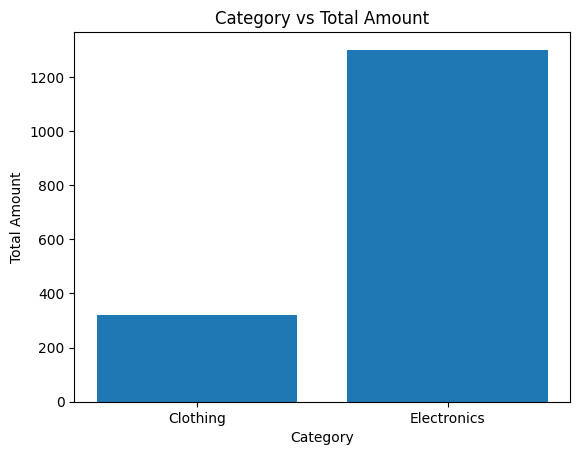


Grouped Data for Chart:
      category  amount
0     Clothing     320
1  Electronics    1300


In [22]:
import pandas as pd
import matplotlib.pyplot as plt

print("\n=== Visualization ===")
pdf = spark.read.format("delta").load("/content/orders_delta").toPandas()
pdf_grouped = pdf.groupby("category")["amount"].sum().reset_index()

plt.bar(pdf_grouped["category"], pdf_grouped["amount"])
plt.xlabel("Category")
plt.ylabel("Total Amount")
plt.title("Category vs Total Amount")
plt.show()

print("\nGrouped Data for Chart:")
print(pdf_grouped)
